In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jane-street-real-time-market-data-forecasting/responders.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/sample_submission.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/features.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=4/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=5/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=6/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=3/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=1/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=8/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=2/part-0.parquet
/kaggle/input/jane-street-real-time-market

In [41]:
# Import packages

import time
import datetime
import os
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

import kaggle_evaluation.jane_street_inference_server

In [42]:
import warnings
warnings.filterwarnings("ignore")

In [43]:
# Set the maximum number of columns to display
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [44]:
# Load the dataset
file_path = '/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=0/part-0.parquet'
df = pd.read_parquet(file_path)

In [45]:
print(df.shape)
display(df.head(10))

(1944210, 92)


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,0,0,1,3.889038,NaN,NaN,NaN,NaN,NaN,0.851033,0.242971,0.263400,-0.891687,11,7,76,-0.883028,0.003067,-0.744703,NaN,-0.169586,NaN,-1.335938,-1.707803,0.910130,NaN,1.636431,1.522133,-1.551398,-0.229627,NaN,NaN,1.378301,-0.283712,0.123196,NaN,NaN,NaN,0.281180,0.269163,0.349028,-0.012596,-0.225932,NaN,-1.073602,NaN,NaN,-0.181716,NaN,NaN,NaN,0.564021,2.088506,0.832022,NaN,0.204797,NaN,NaN,-0.808103,NaN,-2.037683,0.727661,NaN,-0.989118,-0.345213,-1.36224,NaN,NaN,NaN,NaN,NaN,-1.251104,-0.110252,-0.491157,-1.022690,0.152241,-0.659864,NaN,NaN,-0.261412,-0.211486,-0.335556,-0.281498,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504
1,0,0,7,1.370613,NaN,NaN,NaN,NaN,NaN,0.676961,0.151984,0.192465,-0.521729,11,7,76,-0.865307,-0.225629,-0.582163,NaN,0.317467,NaN,-1.250016,-1.682929,1.412757,NaN,0.520378,0.744132,-0.788658,0.641776,NaN,NaN,0.227200,0.580907,1.128879,NaN,NaN,NaN,-1.512286,-1.414357,-1.823322,-0.082763,-0.184119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.835207,-0.002704,-0.621836,NaN,1.172836,NaN,NaN,-1.625862,NaN,-1.410017,1.063013,NaN,0.888355,0.467994,-1.36224,NaN,NaN,NaN,NaN,NaN,-1.065759,0.013322,-0.592855,-1.052685,-0.393726,-0.741603,NaN,NaN,-0.281207,-0.182894,-0.245565,-0.302441,2.965889,1.190077,-0.523998,3.849921,2.626981,5.000000,0.703665,0.216683,0.778639
2,0,0,9,2.285698,NaN,NaN,NaN,NaN,NaN,1.056285,0.187227,0.249901,-0.773050,11,7,76,-0.675719,-0.199404,-0.586798,NaN,-0.814909,NaN,-1.296782,-2.040234,0.639589,NaN,1.597359,0.657514,-1.350148,0.364215,NaN,NaN,-0.017751,-0.317361,-0.122379,NaN,NaN,NaN,-0.320921,-0.958090,-2.436589,0.070999,-0.245239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.420632,-3.515137,-4.677760,NaN,0.535897,NaN,NaN,-0.725420,NaN,-2.294170,1.764551,NaN,-0.120789,-0.063458,-1.36224,NaN,NaN,NaN,NaN,NaN,-0.882604,-0.072482,-0.617934,-0.863230,-0.241892,-0.709919,NaN,NaN,0.377131,0.300724,-0.106842,-0.096792,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828
3,0,0,10,0.690606,NaN,NaN,NaN,NaN,NaN,1.139366,0.273328,0.306549,-1.262223,42,5,150,-0.694008,3.004091,0.114809,NaN,-0.251882,NaN,-1.902009,-0.979447,0.241165,NaN,-0.392359,-0.224699,-2.129397,-0.855287,NaN,NaN,0.404142,-0.578156,0.105702,NaN,NaN,NaN,0.544138,-0.087091,-1.500147,-0.201288,-0.038042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.382074,2.669135,0.611711,NaN,2.413415,NaN,NaN,1.313203,NaN,-0.810125,2.939022,NaN,3.988801,1.834661,-1.36224,NaN,NaN,NaN,NaN,NaN,-0.697595,1.074309,-0.206929,-0.530602,4.765215,0.571554,NaN,NaN,-0.226891,-0.251412,-0.215522,-0.296244,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516
4,0,0,14,0.440570,NaN,NaN,NaN,NaN,NaN,0.955200,0.262404,0.344457,-0.613813,44,3,16,-0.947351,-0.030018,-0.502379,NaN,0.646086,NaN,-1.844685,-1.586560,-0.182024,NaN,-0.969949,-0.673813,-1.282132,-1.399894,NaN,NaN,0.043815,-0.320225,-0.031713,NaN,NaN,NaN,-0.088420,-0.995003,-2.635336,-0.196461,-0.618719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.014600,-2.321076,-3.711265,N

In [46]:
# train_file = "/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet" 
# train_data = pd.read_parquet(train_file, columns=['feature_00', 'responder_6']).head(1000)
# # train_data = pd.read_parquet(train_file)
# test_file = "/kaggle/input/jane-street-real-time-market-data-forecasting/test.parquet/date_id=0" 
# # test_data = pd.read_parquet(test_file, columns=['feature_00', 'responder_6']).head(1000)
# test_data = pd.read_parquet(test_file)

# Step 1: Data Preprocessing

In [47]:
df.describe()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
count,1.944210e+06,1.944210e+06,1.944210e+06,1.944210e+06,0.0,0.0,0.0,0.0,0.0,1.944210e+06,1.944210e+06,1.944210e+06,1.927230e+06,1.944210e+06,1.944210e+06,1.944210e+06,1.944210e+06,1.944210e+06,1.944210e+06,1.889218e+06,1.944147e+06,1.934978e+06,1.944151e+06,1.944151e+06,1.944210e+06,0.0,1.944210e+06,1.944210e+06,1.944210e+06,1.944210e+06,0.0,0.0,1.944210e+06,1.944210e+06,1.944210e+06,0.0,1.922473e+06,1.922473e+06,1.944210e+06,1.944210e+06,1.944210e+06,1.944210e+06,1.944210e+06,1.619478e+06,1.905882e+06,1.847097e+06,1.619478e+06,1.905882e+06,1.847097e+06,1.777836e+06,1.777836e+06,1.944123e+06,1.944210e+06,1.944210e+06,1.651090e+06,1.941920e+06,1.880090e+06,1.651090e+06,1.941920e+06,1.880090e+06,1.944151e+06,1.944151e+06,1.922478e+06,1.944210e+06,1.944210e+06,1.944210e+06,1.790211e+06,1.810936e+06,1.807752e+06,1.777836e+06,1.777836e+06,1.944210e+06,1.944210e+06,1.944210e+06,1.944210e+06,1.944210e+06,1.944210e+06,1.922478e+06,1.922478e+06,1.944194e+06,1.944194e+06,1.944210e+06,1.944210e+06,1.944210e+06,1.944210e+06,1.944210e+06,1.944210e+06,1.944210e+06,1.944210e+06,1.944210e+06,1.944210e+06,1.944210e+06
mean,9.384629e+01,4.240000e+02,1.376638e+01,1.973281e+00,NaN,NaN,NaN,NaN,NaN,-4.463175e-02,-6.456066e-03,-1.984165e-02,5.979728e-02,2.862838e+01,4.778166e+00,1.680162e+02,5.362254e-02,3.939009e-02,5.863355e-02,3.314635e-01,2.559263e-01,3.258700e-01,1.167473e-01,3.453765e-02,3.258846e-01,NaN,4.290666e-01,3.990524e-01,-9.992677e-01,1.962329e-01,NaN,NaN,1.639885e-01,-1.937156e-02,3.812156e-01,NaN,-1.408764e-01,-8.343107e-03,-1.458557e-01,-1.435220e-01,1.190174e-03,3.570056e-02,6.805061e-02,-2.994907e-01,-1.644225e-02,-1.705502e-01,3.686426e-01,8.764663e-02,2.455541e-01,-3.129948e-01,3.386137e-01,-5.229960e-02,-5.336605e-03,-2.105316e-02,5.132496e-02,4.449056e-02,1.181846e-01,-9.201156e-02,6.590640e-03,-1.049684e-01,-7.684646e-02,-3.712558e-02,-3.373222e-02,-6.372424e-03,-1.763194e-02,-3.406668e-02,6.499487e-01,5.568308e-01,5.807831e-01,3.001809e-01,2.318992e-01,6.344803e-02,3.742236e-02,6.147844e-02,4.048006e-02,2.907123e-02,4.857528e-02,-1.185273e-01,-1.201120e-01,-8.346786e-02,-8.451536e-02,-9.682110e-02,-9.805073e-02,8.424639e-03,1.076465e-02,2.412764e-03,1.139089e-02,2.185480e-02,3.326982e-03,1.487634e-03,-4.817980e-04,1.078154e-03
std,4.813196e+01,2.450851e+02,1.108778e+01,9.691969e-01,NaN,NaN,NaN,NaN,NaN,9.479579e-01,9.351186e-01,9.673648e-01,9.228404e-01,2.391003e+01,2.434048e+00,1.742217e+02,1.221367e+00,1.301022e+00,1.230007e+00,1.105641e+00,1.265235e+00,1.173493e+00,1.002713e+00,1.038083e+00,1.026575e+00,NaN,9.436435e-01,8.810623e-01,7.342318e-01,9.947758e-01,NaN,NaN,9.372578e-01,8.290642e-01,1.089110e+00,NaN,9.262206e-01,1.244159e+00,8.324733e-01,8.413032e-01,1.188735e+00,1.014692e+00,1.050283e+00,1.451292e+00,1.582897e+00,1.544337e+00,1.431318e+00,1.578296e+00,1.524057e+00,1.293884e+00,1.283443e+00,1.719946e+00,1.732707e+00,1.774442e+00,9.974949e-01,1.222116e+00,1.045308e+00,9.936872e-01,1.225616e+00,1.055472e+00,1.024146e+00,1

In [48]:
missing_values = df.isnull().sum().reset_index()
missing_values.columns = ['Column', 'Missing Values']

# Display columns with missing values only
missing_values[missing_values['Missing Values'] > 0]

,Column,Missing Values
4,feature_00,1944210
5,feature_01,1944210
6,feature_02,1944210
7,feature_03,1944210
8,feature_04,1944210
12,feature_08,16980
19,feature_15,54992
20,feature_16,63
21,feature_17,9232
22,feature_18,59


In [49]:
# Identify columns where all values are null
null_columns = df.columns[df.isnull().all()]
print(f"Null columns: {list(null_columns)}")

df_cleaned = df.drop(columns=null_columns)

print(f"Original shape: {df.shape}")
print(f"Shape after dropping null columns: {df_cleaned.shape}")

Null columns: ['feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04', 'feature_21', 'feature_26', 'feature_27', 'feature_31']
Original shape: (1944210, 92)
Shape after dropping null columns: (1944210, 83)


In [50]:
missing_values = df_cleaned.isnull().sum().reset_index()
missing_values.columns = ['Column', 'Missing Values']

# Display columns with missing values only
print("total number of columns having any row as null:", len(missing_values[missing_values['Missing Values'] > 0]))

total number of columns having any row as null: 35


In [51]:
# Fill missing values with 0
df_cleaned = df_cleaned.fillna(0)

## Visualization

In [54]:
data = df_cleaned

In [55]:
# print("Plotting graphs:")
# 
# # Determine the number of features and responders
# cols_to_plot = [col for col in data.columns if 'feature' in col or 'responder' in col]
# n_cols = 3  # Number of columns in the grid
# n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols  # Calculate rows needed
# 
# # Create a grid of subplots
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
# axes = axes.flatten()  # Flatten the axes array for easy indexing
# 
# # Visualize distributions of features and responders
# for i, col in enumerate(cols_to_plot):
#     sys.stdout.write(f'\rPlotting graph {i + 1}/{len(cols_to_plot)}...')
#     sys.stdout.flush()
#     
#     sns.histplot(data[col], bins=50, kde=True, ax=axes[i])
#     axes[i].set_title(f'Distribution of {col}')
#     axes[i].set_xlabel(col)
#     axes[i].set_ylabel('Frequency')
#     
# # Hide any unused subplots
# for j in range(i + 1, len(axes)):
#     axes[j].axis('off')
# 
# plt.tight_layout()
# plt.show()
# 
# print("\nPlotting complete.")

## Heatmaps

In [56]:
# data = df_cleaned
# 
# # Set up the figure size for a large heatmap
# plt.figure(figsize=(20, 16))
# 
# # Generate the heatmap for the entire dataset
# sns.heatmap(data.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
# 
# # Add title
# plt.title('Heatmap of Correlations for All Columns')
# plt.show()

### Heatmap between features and first responder

In [57]:
# data = df_cleaned.iloc[:, :-8]
# 
# # Set up the figure size for a large heatmap
# plt.figure(figsize=(25, 20))
# 
# # Generate the heatmap for the entire dataset
# sns.heatmap(data.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
# 
# # Add title
# plt.title('Heatmap of Correlations for responder0')
# plt.show()

### Heatmap between features and second responder

In [58]:
# data = df_cleaned.iloc[:, :-7]
# data = data.drop(data.columns[-2], axis=1)
# 
# # Set up the figure size for a large heatmap
# plt.figure(figsize=(25, 20))
# 
# # Generate the heatmap for the entire dataset
# sns.heatmap(data.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
# 
# # Add title
# plt.title('Heatmap of Correlations for responder1')
# plt.show()

### Heatmap for the target variable (responder_6)

In [59]:
# data = df_cleaned.drop(columns=['responder_0', 'responder_1', 'responder_2', 
#                                  'responder_3', 'responder_4', 'responder_5', 
#                                 'responder_7', 'responder_8'])
# 
# # Set up the figure size for a large heatmap
# plt.figure(figsize=(25, 20))
# 
# # Generate the heatmap for the entire dataset
# sns.heatmap(data.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
# 
# # Add title
# plt.title('Heatmap of Correlations for responder1')
# plt.show()

## Model Training

In [60]:
# 1. Define data
train_data = df_cleaned

# 2. Transform Features and Target
target = 'responder_6'
features = [col for col in train_data.columns if col.startswith("feature_")]

X = train_data[features]  # Feature matrix
y = train_data[target]    # Target variable

# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 4. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Linear Regression

In [61]:
from sklearn.linear_model import LinearRegression

# Train Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Predictions and validation
lm_y_val_pred = linear_model.predict(X_test_scaled)
lm_val_r2 = r2_score(y_test, lm_y_val_pred)
print(f"Linear Regression Validation R^2: {lm_val_r2:.4f}")

Linear Regression Validation R^2: 0.0162


## Random Forests

In [39]:
# from sklearn.ensemble import RandomForestRegressor
# 
# # Train Random Forest model
# rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
# rf_model.fit(X_train_scaled, y_train)
# 
# # Predictions and validation
# rf_y_val_pred = rf_model.predict(X_test_scaled)
# rf_val_r2 = r2_score(y_test, rf_y_val_pred)
# print(f"Random Forest Validation R^2: {rf_val_r2:.4f}")

## XGBoost

In [62]:
from xgboost import XGBRegressor

# # Train XGBoost model
# xgb_model = XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42)
# xgb_model.fit(X_train_scaled, y_train)
# 
# # Predictions and validation
# y_pred = xgb_model.predict(X_test_scaled)
# xgb_val_r2 = r2_score(y_test, y_pred)
# print(f"XGBoost Validation R^2: {xgb_val_r2:.4f}")


In [20]:
# # Finding the best n_estimators and learning_rate values
# from sklearn.metrics import make_scorer
# from sklearn.model_selection import GridSearchCV
# 
# param_grid = {
#     'n_estimators': [50, 80, 100, 200],  # Options for n_estimators
#     'learning_rate': [0.01, 0.05, 0.1]  # Options for learning_rate
# }
# model = XGBRegressor(objective='reg:squarederror')
# # Use make_scorer to create a scorer for R-squared
# r2_scorer = make_scorer(r2_score) 
# 
# grid_search = GridSearchCV(
#     estimator=model, 
#     param_grid=param_grid, 
#     scoring=r2_scorer,  # Use R-squared as the scoring metric
#     cv=5, verbose=2
# )
# grid_search.fit(X_train_scaled, y_train)
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_
# 
# print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ................learning_rate=0.05, n_estimators=50; total time=  14.9s
[CV] END ................learning_rate=0.05, n_estimators=50; total time=  14.5s
[CV] END ................learning_rate=0.05, n_estimators=50; total time=  16.5s
[CV] END ................learning_rate=0.05, n_estimators=50; total time=  14.3s
[CV] END ................learning_rate=0.05, n_estimators=50; total time=  15.6s
[CV] END ................learning_rate=0.05, n_estimators=80; total time=  18.0s
[CV] END ................learning_rate=0.05, n_estimators=80; total time=  18.8s
[CV] END ................learning_rate=0.05, n_estimators=80; total time=  18.2s
[CV] END ................learning_rate=0.05, n_estimators=80; total time=  18.5s
[CV] END ................learning_rate=0.05, n_estimators=80; total time=  19.2s
[CV] END .................learning_rate=0.1, n_estimators=50; total time=  13.6s
[CV] END .................learning_rate=0.1, n_es

In [21]:
# # Find the best max_depth value
# param_grid = {
#     'max_depth': [6, 7, 8, 9, 10]  # Options of max_depth
# }
# 
# # 2. Create the XGBoost model
# model = XGBRegressor(objective='reg:squarederror', learning_rate=0.05, n_estimators=50)  
# 
# # 3. Create the GridSearchCV object
# r2_scorer = make_scorer(r2_score)  # Create scorer for R-squared
# 
# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     scoring=r2_scorer,       # Use R-squared as the scoring metric
#     cv=5, verbose=2 
# )
# 
# # 4. Fit the GridSearchCV to your data
# grid_search.fit(X_train_scaled, y_train)
# 
# # 5. Get the best max_depth and model
# best_max_depth = grid_search.best_params_['max_depth']
# best_model = grid_search.best_estimator_
# 
# print("Best max_depth:", best_max_depth)
# 
# # 6. Evaluate the best model 
# y_pred = best_model.predict(X_test_scaled)
# r2 = r2_score(y_test, y_pred)
# print("R-squared of the best model:", r2)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ........................................max_depth=6; total time=  15.2s
[CV] END ........................................max_depth=6; total time=  14.5s
[CV] END ........................................max_depth=6; total time=  15.4s
[CV] END ........................................max_depth=6; total time=  14.5s
[CV] END ........................................max_depth=6; total time=  15.8s
[CV] END ........................................max_depth=8; total time=  17.3s
[CV] END ........................................max_depth=8; total time=  18.6s
[CV] END ........................................max_depth=8; total time=  17.5s
[CV] END ........................................max_depth=8; total time=  18.1s
[CV] END ........................................max_depth=8; total time=  18.0s
[CV] END .......................................max_depth=10; total time=  24.7s
[CV] END .......................................m

In [22]:
# Finding the best gamma, reg_alpha, and reg_lambda values

# param_grid = {
#        'gamma': [0.1, 0.5, 1, 2],
#        'reg_alpha': [0.1, 0.5, 1, 2],
#        'reg_lambda': [0.1, 0.5, 1, 2]
#    }
# param_grid = {
#        'gamma': [1, 2],
#        'reg_alpha': [1,2],
#        'reg_lambda': [0.1,0.5]
#    }
# 
# # 2. Create the XGBoost model
# model = XGBRegressor(objective='reg:squarederror', learning_rate=0.05, n_estimators=50, max_depth=6)  
# 
# # 3. Create the GridSearchCV object
# r2_scorer = make_scorer(r2_score)  # Create scorer for R-squared
# 
# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     scoring=r2_scorer,       # Use R-squared as the scoring metric
#     cv=5,                   # Number of cross-validation folds (adjust if needed)
#     verbose=2 
# )
# 
# # 4. Fit the GridSearchCV to your data
# grid_search.fit(X_train_scaled, y_train)
# 
# # 5. Get the best parameters and model
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_
# 
# print("Best Hyperparameters:", best_params)
# 
# # 6. Evaluate the best model 
# y_pred = best_model.predict(X_test_scaled)
# r2 = r2_score(y_test, y_pred)
# print("R-squared of the best model:", r2)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ...............gamma=1, reg_alpha=1, reg_lambda=0.1; total time=  14.3s
[CV] END ...............gamma=1, reg_alpha=1, reg_lambda=0.1; total time=  15.1s
[CV] END ...............gamma=1, reg_alpha=1, reg_lambda=0.1; total time=  14.4s
[CV] END ...............gamma=1, reg_alpha=1, reg_lambda=0.1; total time=  15.1s
[CV] END ...............gamma=1, reg_alpha=1, reg_lambda=0.1; total time=  14.6s
[CV] END ...............gamma=1, reg_alpha=1, reg_lambda=0.5; total time=  15.2s
[CV] END ...............gamma=1, reg_alpha=1, reg_lambda=0.5; total time=  14.5s
[CV] END ...............gamma=1, reg_alpha=1, reg_lambda=0.5; total time=  15.3s
[CV] END ...............gamma=1, reg_alpha=1, reg_lambda=0.5; total time=  14.3s
[CV] END ...............gamma=1, reg_alpha=1, reg_lambda=0.5; total time=  15.5s
[CV] END ...............gamma=1, reg_alpha=2, reg_lambda=0.1; total time=  14.2s
[CV] END ...............gamma=1, reg_alpha=2, reg

In [63]:
# 1. Model Training (XGBoost)
model = XGBRegressor(objective='reg:squarederror', 
                     learning_rate=0.05, n_estimators=50, 
                     max_depth=7, 
                     gamma= 1, reg_alpha= 2, reg_lambda= 0.5)
model.fit(X_train_scaled, y_train)

# 2. Model Prediction
y_pred = model.predict(X_test_scaled)

In [64]:
# 3. Calculate Evaluation Metrics

# R-squared
r2 = r2_score(y_test, y_pred)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Custom Accuracy: Percentage of predictions within 10% of the actual values
accuracy = np.mean(np.abs((y_pred - y_test) / y_test) < 0.10) * 100


# 4. Print all metrics
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Custom Accuracy (within 10% of actual): {accuracy:.2f}%")

R-squared: 0.0166
Mean Absolute Error (MAE): 0.6570
Mean Squared Error (MSE): 0.9763
Root Mean Squared Error (RMSE): 0.9881
Mean Absolute Percentage Error (MAPE): 211.99%
Custom Accuracy (within 10% of actual): 1.01%


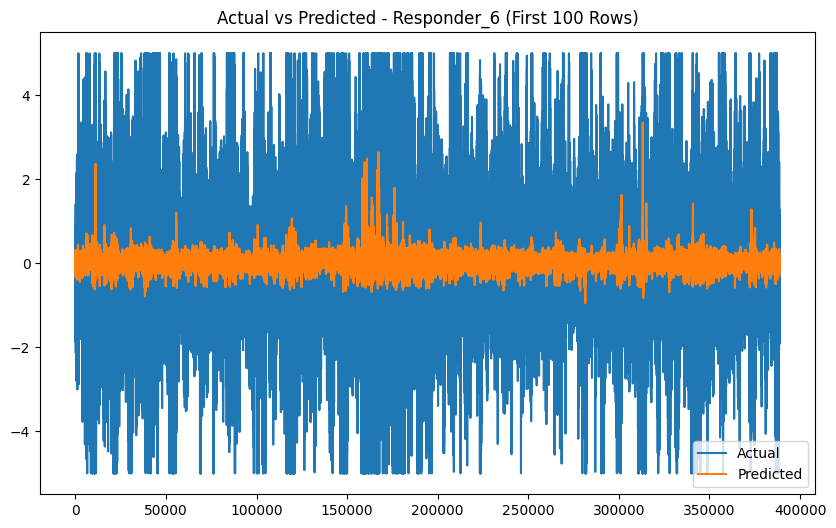

In [65]:
# Optional: Plot the predictions vs actuals
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(y_test.reset_index(drop=True), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted - Responder_6 (First 100 Rows)')
plt.legend()
plt.show()

In [66]:
# Calculate and print weighted R-squared inside your model evaluation section
y_pred = model.predict(X_test_scaled)  # Get your predictions
weights = df_cleaned['weight'][y_test.index] # assuming y_test is a pd.Series

# Function to calculate R² score
def calculate_r2(y_test, y_pred, weights):
    numerator = np.sum(weights * (y_test - y_pred) ** 2)
    denominator = np.sum(weights * (y_test ** 2))
    r2_score = 1 - (numerator / denominator)
    return r2_score

weighted_r2 = calculate_r2(y_test, y_pred, weights)

print(f"Weighted R-squared: {weighted_r2:.4f}") # Print the weighted R-squared

Weighted R-squared: 0.0166


In [77]:
import polars as pl

def predict(test: pl.DataFrame, lags: pl.DataFrame | None) -> pl.DataFrame | pd.DataFrame:
    """
    Predict responder_6 based on test and lagged data.

    Args:
        test (pl.DataFrame): Incoming test data served by the API in Polars format.
        lags (pl.DataFrame | None): Lagged data served by the API in Polars format.

    Returns:
        pl.DataFrame: A Polars DataFrame with 'row_id' and 'responder_6' columns.
    """
    # Convert Polars DataFrame to Pandas for processing
    test_df = test.to_pandas()

    # 1. Match features with test data columns
    available_features = [col for col in features if col in test_df.columns]

    # 2. Preprocess the test data
    test_df = test_df.fillna(0)  # Fill missing values with 0

    # 3. Extract features for prediction
    input_features = test_df[available_features]

    # 4. Scale the features using the trained scaler
    input_features_scaled = scaler.transform(input_features)

    # 5. Generate predictions using the trained model
    predictions_np = model.predict(input_features_scaled)

    # 6. Construct the predictions DataFrame
    predictions = test.select('row_id', pl.lit(0.0).alias('responder_6'))
    predictions = predictions.with_columns(pl.Series('responder_6', predictions_np.ravel()))

    return predictions

In [78]:
inference_server = kaggle_evaluation.jane_street_inference_server.JSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '/kaggle/input/jane-street-real-time-market-data-forecasting/test.parquet',
            '/kaggle/input/jane-street-real-time-market-data-forecasting/lags.parquet',
        )
    )